<a href="https://colab.research.google.com/github/deek2689/CERC_AI/blob/main/GPT2_Safecity_commenting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install accelerate transformers torch -q -U

In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


##  DATA PATHS & HYPERPARAMETERS


In [4]:
train_path = 'https://raw.githubusercontent.com/deek2689/CERC_AI/refs/heads/main/SafeCity%20Datasets/train.csv'
test_path = 'https://raw.githubusercontent.com/deek2689/CERC_AI/refs/heads/main/SafeCity%20Datasets/test.csv'
val_path = 'https://raw.githubusercontent.com/deek2689/CERC_AI/refs/heads/main/SafeCity%20Datasets/dev.csv'
batch_size = 8
learning_rate = 1e-5
num_epochs = 10
patience = 2     # number of epochs to wait for improvement before stopping
max_length = 512

## READING DATA

In [5]:
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

## PREPARING THE DATA

In [6]:
## Defining Instruction text
instruction = "Classify if the following statement falls under commenting related to sexual harassment. The output must be a single label: 'True' or 'False'."

def format_dataset(row):
    """
    Formats the dataset into the required structure for GPT-2 training.
    """
    formatted_text = (
        f"### Instruction:\n{instruction}\n\n"
        f"### Input:\n{row['Description']}\n\n"
        f"### Response:\n"
    )
    label = 1 if row['Category'] == 1 else 0  # Converting category to binary
    return formatted_text, label

def process_dataset(df):
    """
    Processes the data into the defined format
    """
    formatted_texts = []
    labels = []
    for _, row in df.iterrows():
        formatted_text, label = format_dataset(row)
        formatted_texts.append(formatted_text)
        labels.append(label)
    return formatted_texts, labels

# Applying the function
formatted_texts_train, labels_train = process_dataset(train_data)
formatted_texts_val, labels_val = process_dataset(val_data)
formatted_texts_test, labels_test = process_dataset(test_data)


## Tokenization

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.bos_token  # or eos_token // Since GPT2 doesnt have a pad token
tokenizer.padding_side = "left" # GPT2 being a decoder model, it uses the last token for prediction so padding on the left

def tokenize_dataset(formatted_texts, labels, max_length=512):
    tokenized = tokenizer(
        formatted_texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    input_ids = tokenized['input_ids']
    attention_mask = tokenized['attention_mask']
    labels_tensor = torch.tensor(labels)
    return TensorDataset(input_ids, attention_mask, labels_tensor)

train_dataset = tokenize_dataset(formatted_texts_train, labels_train, max_length=max_length)
val_dataset = tokenize_dataset(formatted_texts_val, labels_val, max_length=max_length)
test_dataset = tokenize_dataset(formatted_texts_test, labels_test, max_length=max_length)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

## CREATING DATALOADERS

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

## SETTING UP DEVICE

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
device


device(type='cuda')

## MODEL AND OPTIMIZER

In [10]:
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## TRAINING - EVAL LOOP WITH EARLY STOPPING

In [17]:
best_val_loss = float("inf")
epochs_unimproved = 0
train_losses = [] # To store training loss after each epoch
val_losses = [] ## Similarly for validation losses

for epoch in range(num_epochs):
  print(f"Epoch {epoch + 1}/{num_epochs}")
  model.train()
  total_train_loss = 0

  for batch in tqdm(train_dataloader, desc = 'Training'):
    input_ids, attention_masks, batch_labels = batch
    input_ids, attention_masks, batch_labels = input_ids.to(device), attention_masks.to(device), batch_labels.to(device)
    optimizer.zero_grad()
    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_masks,
        labels = batch_labels
    )
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    total_train_loss += loss.item()
  avg_train_loss = total_train_loss/len(train_dataloader)
  train_losses.append(avg_train_loss)
  print(f"Training Loss (Average): {avg_train_loss}")

  #Validation Loop
  model.eval()
  total_val_loss = 0
  val_predictions = []
  val_true_labels = []

  with torch.no_grad():
    for batch in tqdm(val_dataloader, desc = 'Validation'):
      input_ids, attention_masks, batch_labels = batch
      input_ids, attention_masks, batch_labels = input_ids.to(device), attention_masks.to(device), batch_labels.to(device)
      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_masks,
          labels = batch_labels
      )
      loss = outputs.loss
      total_val_loss += loss.item()

      logits = outputs.logits
      probs = torch.nn.functional.softmax(logits, dim=-1)
      pred_classes = torch.argmax(probs, dim=-1)

      val_predictions.extend(pred_classes.cpu().numpy())
      val_true_labels.extend(batch_labels.cpu().numpy())

  avg_val_loss = total_val_loss / len(val_dataloader)
  val_losses.append(avg_val_loss)
  val_macro_f1 = f1_score(val_true_labels, val_predictions, average = 'macro')
  val_f1_score = f1_score(val_true_labels, val_predictions)

  print(f"  Validation loss: {avg_val_loss}")
  print(f"  Validation Macro F1 score: {val_macro_f1}")
  print(f"  Validation F1 score: {val_f1_score}")

  ## Early Stopping

  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    epochs_unimproved = 0
    torch.save(model.state_dict(), "best_model.pt")
  else:
    epochs_unimproved += 1
    print(f" No improvement in validation loss for {epochs_unimproved} epoch(s).")
    if epochs_unimproved >= patience:
      print("Stopping early due to no improvement in validation loss")
      break



Epoch 1/10


Training: 100%|██████████| 901/901 [11:50<00:00,  1.27it/s]


Training Loss (Average): 0.6581581621932137


Validation: 100%|██████████| 124/124 [00:19<00:00,  6.43it/s]


  Validation loss: 0.5508495348115121
  Validation Macro F1 score: 0.6830049261083744
  Validation F1 score: 0.5517241379310345
Epoch 2/10


Training: 100%|██████████| 901/901 [11:51<00:00,  1.27it/s]


Training Loss (Average): 0.5077504305361246


Validation: 100%|██████████| 124/124 [00:19<00:00,  6.42it/s]


  Validation loss: 0.4671707904386905
  Validation Macro F1 score: 0.7657273918741809
  Validation F1 score: 0.6904761904761905
Epoch 3/10


Training: 100%|██████████| 901/901 [11:51<00:00,  1.27it/s]


Training Loss (Average): 0.47661825365383803


Validation: 100%|██████████| 124/124 [00:19<00:00,  6.42it/s]


  Validation loss: 0.4538575624746661
  Validation Macro F1 score: 0.7724852555701179
  Validation F1 score: 0.6994047619047619
Epoch 4/10


Training: 100%|██████████| 901/901 [11:51<00:00,  1.27it/s]


Training Loss (Average): 0.45280858003570557


Validation: 100%|██████████| 124/124 [00:19<00:00,  6.42it/s]


  Validation loss: 0.43721192955009397
  Validation Macro F1 score: 0.796724245253657
  Validation F1 score: 0.7486772486772487
Epoch 5/10


Training: 100%|██████████| 901/901 [11:51<00:00,  1.27it/s]


Training Loss (Average): 0.43871352963819354


Validation: 100%|██████████| 124/124 [00:19<00:00,  6.42it/s]


  Validation loss: 0.43778160418714246
  Validation Macro F1 score: 0.7916912240192391
  Validation F1 score: 0.7350901525658807
 No improvement in validation loss for 1 epoch(s).
Epoch 6/10


Training: 100%|██████████| 901/901 [11:51<00:00,  1.27it/s]


Training Loss (Average): 0.4248885814013677


Validation: 100%|██████████| 124/124 [00:19<00:00,  6.41it/s]

  Validation loss: 0.4392430724636201
  Validation Macro F1 score: 0.7935898857713208
  Validation F1 score: 0.7352112676056338
 No improvement in validation loss for 2 epoch(s).
Stopping early due to no improvement in validation loss


In [23]:
# Reload the best model
model.load_state_dict(torch.load("best_model.pt"))
print("Loaded the best model for final evaluation.")

<ipython-input-23-0b7daee3da4d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


Loaded the best model for final evaluation.


## Visualizing training and validation losses

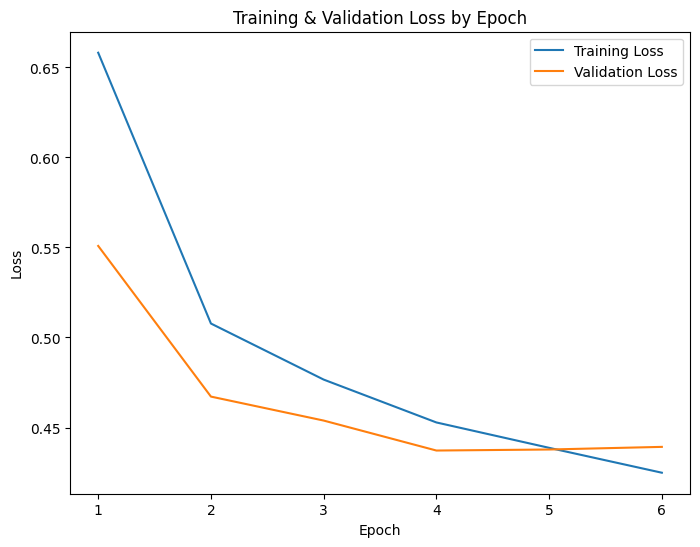

In [3]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title("Training & Validation Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## TESTING LOOP

In [25]:
model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        input_ids, attention_masks, batch_labels = batch
        input_ids, attention_masks, batch_labels = input_ids.to(device), attention_masks.to(device), batch_labels.to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_masks,
            labels=batch_labels
        )

        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_classes = torch.argmax(probs, dim=1)

        test_predictions.extend(pred_classes.cpu().numpy())
        test_true_labels.extend(batch_labels.cpu().numpy())



Testing: 100%|██████████| 213/213 [00:49<00:00,  4.27it/s]


## Calculating Performance Metrics

In [26]:
test_macro_f1 = f1_score(test_true_labels, test_predictions, average='macro')
test_F1 = f1_score(test_true_labels, test_predictions)
test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_precision = precision_score(test_true_labels, test_predictions)
test_recall = recall_score(test_true_labels, test_predictions)

print(f"\nTest Macro F1 score: {test_macro_f1}")
print(f"Test Regular F1 score: {test_F1}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print("\nClassification Report:")
print(classification_report(test_true_labels, test_predictions))


Test Macro F1 score: 0.8043051771117167
Test Regular F1 score: 0.7466666666666667
Test Accuracy: 0.8212815990593768
Test Precision: 0.8205128205128205
Test Recall: 0.6850152905198776

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1047
           1       0.82      0.69      0.75       654

    accuracy                           0.82      1701
   macro avg       0.82      0.80      0.80      1701
weighted avg       0.82      0.82      0.82      1701

